# Entraînement et Optimisation de XGBoost\n\nCe notebook implémente l'entraînement d'un modèle XGBoost avec une approche de base et une approche optimisée (Optuna + TimeSeriesSplit).\n\nObjectifs :\n1. Préparer les données (gestion des catégories).\n2. Entraîner un modèle de base avec les paramètres suggérés.\n3. Optimiser les hyperparamètres via Optuna et Validation Croisée Temporelle.\n4. Évaluer et sauvegarder le meilleur modèle.\n

In [18]:
import sys
# Force installation if needed
!{sys.executable} -m pip install optuna xgboost --break-system-packages

import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import os
import pickle
import warnings

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.INFO)

os.makedirs('trained_models', exist_ok=True)


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Chargement des Données

In [19]:
train_X_path = 'donnees_pretraitees/X_train_7_jours.csv'
train_y_path = 'donnees_pretraitees/y_train_7_jours.csv'
test_X_path = 'donnees_pretraitees/X_test_7_jours.csv'
test_y_path = 'donnees_pretraitees/y_test_7_jours.csv'

X_train = pd.read_csv(train_X_path)
y_train = pd.read_csv(train_y_path)
X_test = pd.read_csv(test_X_path)
y_test = pd.read_csv(test_y_path)

if y_train.shape[1] == 1: y_train = y_train.iloc[:, 0]
if y_test.shape[1] == 1: y_test = y_test.iloc[:, 0]

# Conversion Category pour XGBoost (enable_categorical=True)
cat_cols = ['Category', 'Region', 'Weather Condition', 'Seasonality']
for col in cat_cols:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
    if col in X_test.columns:
        X_test[col] = X_test[col].astype('category')

print(f"Train: {X_train.shape}, Test: {X_test.shape}")



Train: (56000, 65), Test: (14100, 65)


In [20]:
# Supprimez les features qui causent le leakage
features_to_drop = ['moyenne_ventes_produit', 'moyenne_ventes_magasin']
X_train_clean = X_train.drop(columns=features_to_drop)
X_test_clean = X_test.drop(columns=features_to_drop)

# Recréez vos DMatrix
dtrain_clean = xgb.DMatrix(X_train_clean, label=y_train, enable_categorical=True)
dtest_clean = xgb.DMatrix(X_test_clean, label=y_test, enable_categorical=True)

## 2. Modèle de Base
Entraînement avec les paramètres fournis par l'utilisateur.

In [21]:
base_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,              
    'learning_rate': 0.05,       
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'enable_categorical': True
}

""" dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True) """

print("Training Base Model...")
base_model = xgb.train(
    base_params,
    dtrain_clean,
    num_boost_round=1000,
    evals=[(dtrain_clean, 'Train'), (dtest_clean, 'Test')],
    early_stopping_rounds=50,
    verbose_eval=100
)

preds_base = base_model.predict(dtest_clean)
rmse_base = np.sqrt(mean_squared_error(y_test, preds_base))
print(f"Base Model RMSE: {rmse_base:.4f}")

Training Base Model...
[0]	Train-rmse:109.10374	Test-rmse:108.98551
[52]	Train-rmse:107.14668	Test-rmse:109.06468
Base Model RMSE: 109.0647


## 3. Optimisation Optuna avec TimeSeriesSplit

In [ ]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'enable_categorical': True,
        'n_jobs': -1,
        'random_state': 42,
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # Réduire la plage
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
    }
    
    tscv = TimeSeriesSplit(n_splits=3)
    scores = []
    
    # UTILISER X_train_clean au lieu de X_train
    for train_idx, val_idx in tscv.split(X_train_clean):
        X_tr, X_val = X_train_clean.iloc[train_idx], X_train_clean.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        d_tr = xgb.DMatrix(X_tr, label=y_tr, enable_categorical=True)
        d_val = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
        
        model = xgb.train(
            params,
            d_tr,
            num_boost_round=1000,  # Augmenter le nombre de rounds
            evals=[(d_val, 'Val')],
            early_stopping_rounds=50,  # Augmenter early stopping
            verbose_eval=False
        )
        
        p_val = model.predict(d_val)
        rmse = np.sqrt(mean_squared_error(y_val, p_val))
        scores.append(rmse)
        
    return np.mean(scores)



[I 2026-01-06 10:05:22,303] A new study created in memory with name: no-name-2b672d27-cebf-487c-bbd6-c24b5290d855


Optimization starts...


[I 2026-01-06 10:05:24,104] Trial 0 finished with value: 109.56862822502207 and parameters: {'max_depth': 5, 'learning_rate': 0.17484501809623149, 'subsample': 0.8474540822049024, 'colsample_bytree': 0.6220071690265386, 'min_child_weight': 6, 'gamma': 4.322025037381346, 'reg_alpha': 0.022036340118623404, 'reg_lambda': 0.11269812711641924}. Best is trial 0 with value: 109.56862822502207.
[I 2026-01-06 10:05:27,112] Trial 1 finished with value: 110.97234849508334 and parameters: {'max_depth': 7, 'learning_rate': 0.20094728145701551, 'subsample': 0.8646140229623103, 'colsample_bytree': 0.9988417300422375, 'min_child_weight': 4, 'gamma': 2.7046965145116992, 'reg_alpha': 1.5787308594152065e-07, 'reg_lambda': 2.343766300276826e-06}. Best is trial 0 with value: 109.56862822502207.
[I 2026-01-06 10:05:29,923] Trial 2 finished with value: 109.47835099857684 and parameters: {'max_depth': 9, 'learning_rate': 0.046918372243811665, 'subsample': 0.5462341903602176, 'colsample_bytree': 0.911924409567

Best Params: {'max_depth': 15, 'learning_rate': 0.010647268107600555, 'subsample': 0.6855989031628121, 'colsample_bytree': 0.7111919729654088, 'min_child_weight': 1, 'gamma': 3.320141713246765, 'reg_alpha': 0.00011180473760217449, 'reg_lambda': 5.0544460617766546e-08}


## 4. Entraînement Final et Évaluation

Training Final Model...
[0]	Test-rmse:108.99049
[50]	Test-rmse:109.11079

Final Optimized RMSE: 109.1108
Final Optimized MAE: 89.5934


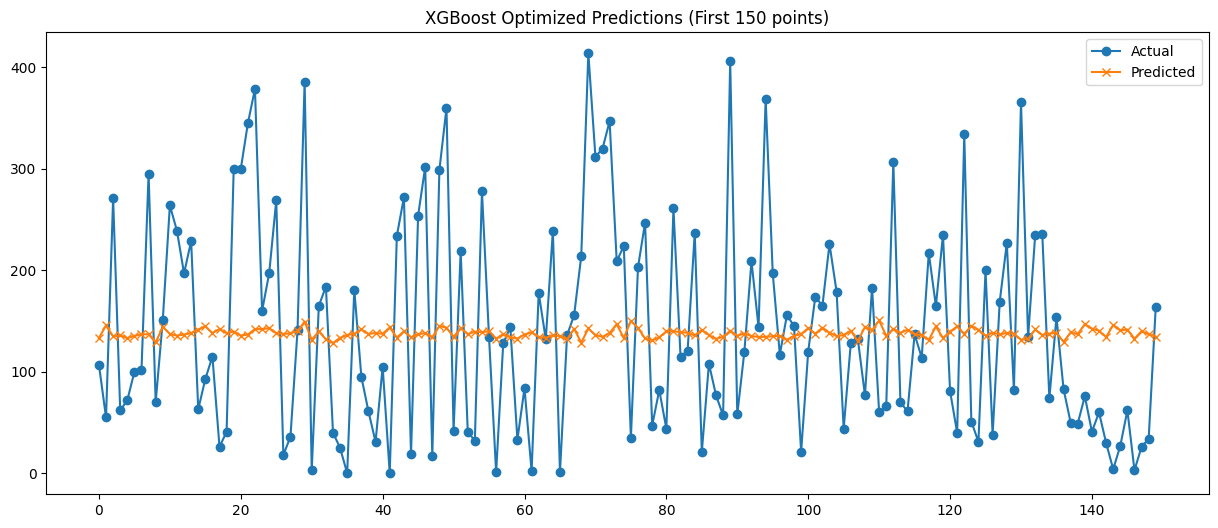

In [23]:
final_params = study.best_params
final_params.update({
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'enable_categorical': True,
    'random_state': 42,
    'n_jobs': -1
})

print("Training Final Model...")
final_model = xgb.train(
    final_params,
    dtrain_clean,
    num_boost_round=1500,
    evals=[(dtest_clean, 'Test')],
    early_stopping_rounds=50,
    verbose_eval=100
)

# Predictions
preds = final_model.predict(dtest_clean)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)

print(f"\nFinal Optimized RMSE: {rmse:.4f}")
print(f"Final Optimized MAE: {mae:.4f}")

# Save
with open('trained_models/xgboost_model_optimized.pkl', 'wb') as f:
    pickle.dump(final_model, f)
    
with open('trained_models/xgboost_metrics_optimized.txt', 'w') as f:
    f.write(f"RMSE: {rmse}\nMAE: {mae}\nBest Params: {final_params}")

# Viz
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:150], label='Actual', marker='o')
plt.plot(preds[:150], label='Predicted', marker='x')
plt.title("XGBoost Optimized Predictions (First 150 points)")
plt.legend()
plt.show()

In [24]:
# Vérifiez que vos features varient
print(X_train.describe())
print(f"Target range: {y_train.min()} to {y_train.max()}")

       Product_ID_encoded  Store_ID_encoded  moyenne_ventes_produit  \
count        56000.000000      56000.000000            56000.000000   
mean             9.500000          2.000000              136.464870   
std              5.766333          1.414226                1.652773   
min              0.000000          0.000000              133.468399   
25%              4.750000          1.000000              135.416005   
50%              9.500000          2.000000              136.440766   
75%             14.250000          3.000000              137.476471   
max             19.000000          4.000000              139.116826   

       moyenne_ventes_magasin         annee          mois  semaine_annee  \
count            56000.000000  56000.000000  56000.000000   56000.000000   
mean               136.464870   2022.348214      5.562500      22.385714   
std                  1.249744      0.476409      3.273246      14.319239   
min                135.140219   2022.000000      1.00000

In [ ]:
df = df.drop(columns=["Ville"]) print(df)